In [1]:
# Import the libraries for the datahandling
import math, json, collections, itertools
import numpy as np
import pandas as pd

#Visualistation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

#HTML visualistation
from bokeh.io import output_file, show, output_notebook

from bokeh.models.glyphs import Line as Line_glyph
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.transform import dodge, factor_cmap
from bokeh.models.widgets import Tabs, Panel, Paragraph
from bokeh.models import FactorRange,Range1d,Circle, ColumnDataSource, MultiLine,EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import column, row


#Data reading/writing libraries
import csv

#import network tools
import networkx as nx

In [2]:
#set global variables
%matplotlib inline     
sns.set(color_codes=True)
sns.set_theme(style="whitegrid")

#Set standard visualization parameters
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = [20, 5]


#notebook display parameter
pd.options.display.float_format = '{:,.2f}'.format

Zones = ['01', '02','03','04','05','06','07','08','09','10','11','12','13','14','15','21','22','31','32']
Zones_short =  ['01','03','05','07','09','11','13','15','21','22','31','32']
country_order=['CH','NO','DE', 'SE', 'FI','FR','BE','NL','AT','IE','DK','GB'] #allways the same order
country_colors=['lightblue','blue','red','lime','green','brown','chartreuse','crimson','darkgreen','darkorange','deepskyblue','fuchsia']

# Starting point
Read the data

1. pick historie
2. masterlist

In [3]:
# Read te pick information for statistical information
picklist_org=pd.read_csv('Pickdata.txt',delimiter=',')

#adjust column name for convienence
picklist_org.rename(columns={"Inventory Sku": 'InventorySku'},inplace=True)

picklist_org.drop_duplicates(keep='first',inplace=True)

In [4]:
#read the masterlist
masterlist_path="new_masterlist.xlsx"

masterlist= pd.read_excel(masterlist_path)

#masterlist=pd.read_csv('SKU list export.txt',delimiter=';',encoding='cp1252')
#masterlist=pd.read_excel("H:\\Caps\\PTL_Files\\Venray_PTL_Master_list.xls",sheet_name='MASTER LIST')

masterlist.drop_duplicates(subset=['Inv_Sku'],keep='first',inplace=True)

#seperate the location in the fields zone = first 2 positions, Level = Letter, of letter numer letter and finaly the lane numer = last to numbers
masterlist['zone']=masterlist.Locator.str.extract(r"(\d{2})")
masterlist['level']=masterlist.Locator.str.extract(r"([A-Z][0-9][A-Z]|[A-D])")
masterlist['lane']=masterlist.Locator.str.extract(r"(\d{2}$)")

#Set if it is a WBS location
masterlist['WBC']= masterlist.Locator.str.len()>5

#temp placeholder until fields are incorporated via other files

masterlist['Type']=""


In [5]:
#Read the file with the new locations / extract this from the balance sheet
new_location_path="Balance_sheet_current_2023.xlsx"

new_locations= pd.read_excel(new_location_path,sheet_name='USE_FOR_PYTHON')
new_locations

new_locations.drop_duplicates(subset=['Inv_Sku'],keep='first',inplace=True)

#seperate the location in the fields zone = first 2 positions, Level = Letter, of letter numer letter and finaly the lane numer = last to numbers
new_locations['new_zone']=new_locations.New_Locator.str.extract(r"(\d{2})")
new_locations['new_level']=new_locations.New_Locator.str.extract(r"([A-Z][0-9][A-Z]|[A-D])")
new_locations['new_lane']=new_locations.New_Locator.str.extract(r"(\d{2}$)")

#Set if it is a WBS location
new_locations['new_WBC']= new_locations.New_Locator.str.len()>5


In [6]:
# create the picklist with only sku's currently on the line
picklist=pd.merge(picklist_org, masterlist[['Inv_Sku','Locator']], left_on='InventorySku', right_on='Inv_Sku',how='right')
picklist_org.shape[0]-picklist.shape[0]

5986

In [7]:
#Rearange the date field seperate the month
picklist['month']=pd.to_datetime(picklist['Date'], format='%m/%d/%Y %H:%M:%S').dt.strftime('%m')
picklist.Date=pd.to_datetime(picklist['Date'], format='%m/%d/%Y %H:%M:%S').dt.strftime('%Y-%m-%d')

#Get the zone information from the locator field
picklist['zone']=picklist.Locator.str.extract(r"(\d{2})")

In [8]:
picklist['level']=picklist.Locator.str.extract(r"([A-Z][0-9][A-Z]|[A-D])")
picklist['lane']=picklist.Locator.str.extract(r"(\d{2}$)")

#Set if it is a WBS location
picklist['WBC']= picklist.Locator.str.len()>5


In [9]:
'''
Function --> get the area 
'''

def Area_set(zone):
    if zone == "01" or zone == "02":
        return "A1"
    if zone == "03" or zone == "04":
        return "A2"
    if zone == "05" or zone == "06":
        return "A3"
    if zone == "07" or zone == "08":
        return "A4"
    if zone == "09" or zone == "10":
        return "A5"
    if zone == "11" or zone == "12":
        return "B1"
    if zone == "13" or zone == "14":
        return "B2"
    if zone == "15":
        return "B3"
    return "C"
    
picklist['Area']=picklist.apply(lambda x: Area_set(x['zone']),axis=1)


In [10]:
#select a working set
newdf=picklist.query('month == "08"').copy() #month == "04" or month == "05" or
print("Number of orderlines {}\nNumber of eaches {}\nNumber of boxes {}\nNumber of orders {}".format(newdf.shape[0],newdf.Picked.sum(),newdf.Boxnr.nunique(),newdf.Ordernr.nunique()))
print("Number of orderlines {}\nNumber of eaches {}\nNumber of boxes {}\nNumber of orders {}".format(picklist.shape[0],picklist.Picked.sum(),picklist.Boxnr.nunique(),picklist.Ordernr.nunique()))

Number of orderlines 673618
Number of eaches 1001079.0
Number of boxes 127430
Number of orders 126014
Number of orderlines 2034145
Number of eaches 2943242.0
Number of boxes 392579
Number of orders 388252


In [11]:
#calculate the number of boxes for each area.
Area = pd.DataFrame(newdf.groupby(['Area']).agg({'Boxnr':pd.Series.nunique}).reset_index())
tmp_= newdf.Boxnr.nunique()
Area['perc'] = Area.Boxnr / tmp_
Area

,Area,Boxnr,perc
0,A1,58596,0.46
1,A2,59789,0.47
2,A3,55371,0.43
3,A4,60310,0.47
4,A5,58445,0.46
5,B1,48369,0.38
6,B2,47867,0.38
7,B3,28502,0.22
8,C,43851,0.34


In [12]:
#calculate the number of stops
stops = pd.DataFrame(newdf.groupby(['Country','Boxnr']).agg( {'Area': pd.Series.nunique}).reset_index())
stops.groupby('Country')['Area'].mean()

Country
AT   3.87
BE   3.73
CH   4.06
DE   3.56
DK   3.52
FI   4.33
FR   3.51
GB   2.98
IE   3.06
MT   3.68
NL   3.09
NO   3.92
SE   3.75
Name: Area, dtype: float64

In [13]:
lanes = ['01','03', '05', '07','09','11','13','21','23','25','27','29','31','33','02','04','06','08','10','12','14','22','24','26','28','30','32','34'] 
mezzanine = ['01','03', '05', '07','09', '11','13','21','23','25','27','29','31','33','41','43','45','47','49','51','53']

lane_distance={'01':1,      '03':2,      '05':3,      '07':4,      '09':5,      '11':6,        '13':7,        '21':8,       '23':9,
               '25':10,     '27':11,     '29':12,     '31':13,     '33':14,     '02':1.5,      '04':2.5,      '06':3.5,     '08':4.5,
               '10':5.5,    '12':6.5,    '14':7.5,    '22':8.5,    '24':9.5,    '26':10.5,     '28':11.5,     '30':12.5,    '32':13.5,
               '34':14.5,   '41':15,     '43':16,     '45':17,     '47':18,     '49':19,       '51':20,       '53':21}

In [14]:
#For the picker, the place in the flowrack determines the walking distance from location to box
#in the future we will try to minimise the walking distance, therefor we calculate the distanc from the box to the location, based on the location numer
#The zone it self is not relevant for the walking distance

def weightfactor(zone,level,lane): 
    #Declare the weights for each lane to get 

    # 
    # The standing position is not equal in each zone
    # for eache zone we set the standing position in the zone_list
    zone_list = [0, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 7, 
                 0, 0, 0,  0,  0, 12, 6 ]
    x=1
    ilane=int(lane)
    #we ignore the zones 31/33 for now 
    if int(zone) > 22:
        return 3
    
    if level == "A":
        x += 0.5
    if level == "B":
        x += 0.25
    if level == "C":
        x +=0
    if level == "D":
        x += 0.25

   
    if ilane <= 54:
        # to be sure check if the zone is correct
        try:
            y = zone_list[int(zone)]
        except:
            print(zone)
        # calculate the distance between the lane where the picker is standing (in zone list) and the lane of the product
        try:
            x += abs(zone_list[int(zone)] - lane_distance[lane])*0.25
        except:
            print(zone,lane)
    else:
        x +=1

    return x
    
newdf['Walk_Factor']=newdf.apply(lambda x: weightfactor(x['zone'],x['level'],x['lane']),axis=1)


In [15]:
#group by date to get the picks for each day
dailypicks=pd.DataFrame(newdf.groupby(['Date'])['Picked'].sum().reset_index())

#dailypicks=pd.DataFrame(picklist.query('InventorySku == "4472BE"').groupby(['Date'])['Picked'].sum().reset_index())
#Total number of picks
dailypicks.Picked.sum()

1001079.0

In [16]:
# Overview of all lines per order per country
# Split per country
country_order=['FR','DE','BE','NL','AT','DK','GB','IE','SE','FI','NO','CH'] #allways the same order
country_colors=['lightblue','blue','red','lime','green','brown','chartreuse','crimson','darkgreen','darkorange','deepskyblue','fuchsia']
country_colors=['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

## 2 Lines per order

In [17]:
# use this to get all boxes with X lines and then get the most picked Sku's

#get the number of lines per box
boxpicks=pd.DataFrame(newdf.groupby(['Ordernr'])['InventorySku'].count().reset_index())

#set a filter with alle boxes with X lines
filter1=boxpicks.query('InventorySku == 1')['Ordernr'].tolist()

#get the sku's picked most in the filtered selection
overview = pd.DataFrame(newdf[newdf.Ordernr.isin(filter1)].groupby('InventorySku').count().nlargest(5,columns='Picked').reset_index())
overview[['InventorySku','Picked']]

# There will be a difference when this is run based on the order level or on boxlevel.
# When SKU's are beeing relocated the boxlevel can change, orderlevel can not.

,InventorySku,Picked
0,A497,1871
1,A350,539
2,A080,516
3,A349,353
4,A346,297


In [18]:
#create a list with all boxes containing a particular SKU

filter1=newdf.query('InventorySku == "A497"')['Boxnr'].tolist()

#use this list to COUNT all sku's which are in the same box as the selected SKu in the above filter
pd.DataFrame(newdf[newdf.Boxnr.isin(filter1)].groupby(['InventorySku','zone'])['Boxnr'].count().nlargest(5).reset_index())

,InventorySku,zone,Boxnr
0,A497,21,1871


In [19]:
#Create a datatable with per country the number of eaches/lines split on zone level
pickszonecountry=pd.DataFrame(newdf.groupby(['Area','Country']).agg({'Picked': 'sum', 'InventorySku': 'count'}).reset_index())
percentage_table=pd.DataFrame(pd.pivot_table(pickszonecountry,
                              index=['Country'],
                              columns=['Area'],
                              values='InventorySku',
                              aggfunc=[np.sum],
                              margins=True, 
                              margins_name='Total')).set_axis( [ 'A1', 'A2','A3','A4','A5','B1','B2','B3','C','Tot'],
                                                              axis='columns',
                                                              copy=False)

In [20]:
# 1. calculate the percentage per Area
# 2. calculate the difference between the actual percentage and the target percentage
percentage_zone = [0.135, 0.135,0.135,0.135,0.135,0.11,0.11,0.055,0.05]
for num,i in enumerate([ 'A1', 'A2','A3','A4','A5','B1','B2','B3','C']):
    percentage_table[f'{i}_p'] = (percentage_table[i]/percentage_table['Tot']) - percentage_zone[num]

#group per area the sku's country differentiated
lineszonecountry=pd.DataFrame(newdf.groupby(['Area','Country','InventorySku']).agg({'Picked': 'count',}).reset_index())

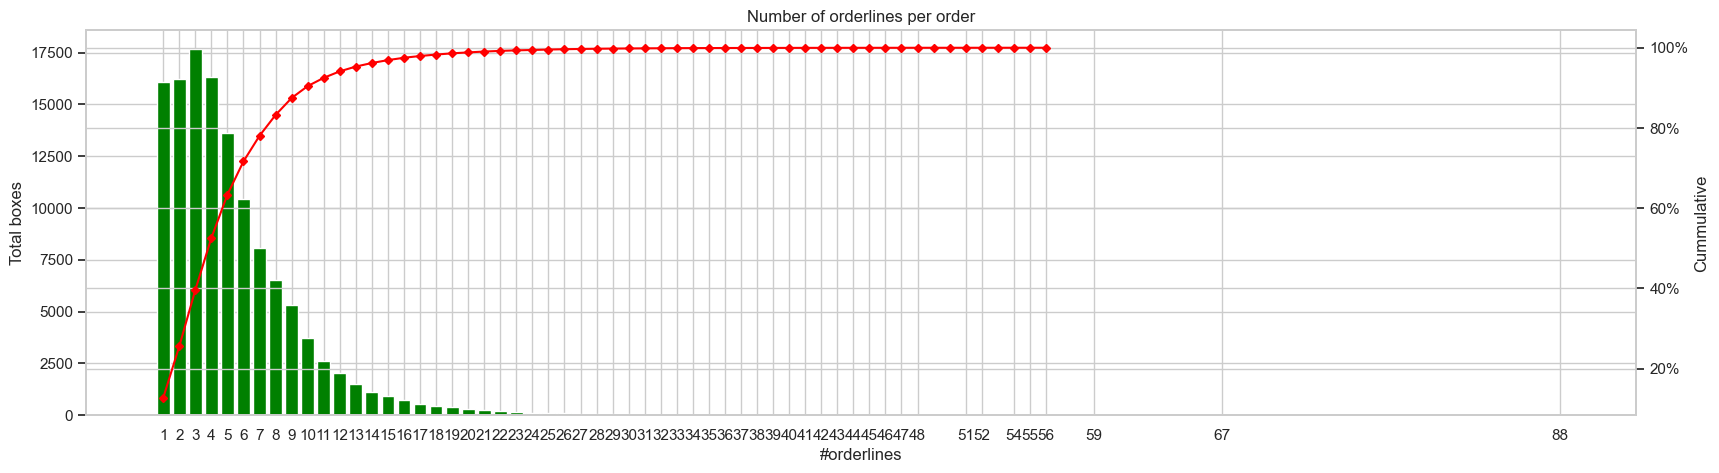

In [21]:
# Overview of the lines per order

picksperbox=pd.DataFrame(boxpicks.groupby(['InventorySku']).count().reset_index())
df_tmp=picksperbox.sort_values(by='InventorySku',ascending=True)

#calculate the running total of orders
df_tmp['cumperc'] = df_tmp['Ordernr'].cumsum()/df_tmp.Ordernr.sum()*100
df_tmp = df_tmp.reset_index()

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(df_tmp.InventorySku, df_tmp['Ordernr'], color='green')

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_tmp.index+1, df_tmp['cumperc'], color='red', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.set_xticks(df_tmp.InventorySku)
ax.set_title("Number of orderlines per order");
ax.set_xlabel("#orderlines");
ax.set_ylabel("Total boxes");
ax2.set_ylabel("Cummulative");

#display Pareto chart
plt.show()

In [22]:
#show the result
percentage_table.style.highlight_max(subset = ['A1','A2','A3','A4','A5','B1','B2','B3','C'],color='green',axis=1)\
.highlight_max(subset = ['A1_p','A2_p','A3_p','A4_p','A5_p','B1_p','B2_p','B3_p','C_p'],color='green',axis=1)\
    .format("{:.2f}",na_rep="-")\
        .highlight_min(subset = ['A1','A2','A3','A4','A5','B1','B2','B3','C'],color='red',axis=1)\
            .highlight_min(subset =['A1_p','A2_p','A3_p','A4_p','A5_p','B1_p','B2_p','B3_p','C_p'] ,color='red',axis=1)

,A1,A2,A3,A4,A5,B1,B2,B3,C,Tot,A1_p,A2_p,A3_p,A4_p,A5_p,B1_p,B2_p,B3_p,C_p
Country,,,,,,,,,,,,,,,,,,,
AT,4826.00,4851.00,5838.00,5388.00,7179.00,5834.00,7265.00,2639.00,1864.00,45684.00,-0.03,-0.03,-0.01,-0.02,0.02,0.02,0.05,0.00,-0.01
BE,19039.00,24930.00,13049.00,20014.00,18591.00,14437.00,17816.00,5950.00,17805.00,151631.00,-0.01,0.03,-0.05,-0.00,-0.01,-0.01,0.01,-0.02,0.07
CH,5440.00,4416.00,8714.00,4452.00,8323.00,5699.00,7301.00,5783.00,4173.00,54301.00,-0.03,-0.05,0.03,-0.05,0.02,-0.01,0.02,0.05,0.03
DE,12291.00,12958.00,15741.00,14354.00,16416.00,18311.00,21022.00,8072.00,5551.00,124716.00,-0.04,-0.03,-0.01,-0.02,-0.00,0.04,0.06,0.01,-0.01
DK,994.00,533.00,1201.00,5561.00,2252.00,1092.00,712.00,616.00,3460.00,16421.00,-0.07,-0.10,-0.06,0.20,0.00,-0.04,-0.07,-0.02,0.16
FI,1021.00,448.00,1349.00,1035.00,345.00,523.00,1283.00,226.00,1040.00,7270.00,0.01,-0.07,0.05,0.01,-0.09,-0.04,0.07,-0.02,0.09
FR,16770.00,16149.00,16073.00,16205.00,19175.00,11798.00,19274.00,10833.00,15900.00,142177.00,-0.02,-0.02,-0.02,-0.02,-0.00,-0.03,0.03,0.02,0.06
GB,832.00,168.00,423.00,477.00,410.00,13.00,147.00,17.00,841.00,3328.00,0.11,-0.08,-0.01,0.01,-0.01,-0.11,-0.07,-0.05,0.20
IE,2914.00,614.00,1115.00,2127.00,1830.00,90.00,516.00,63.00,3354.00,12623.00,0.10,-0.09,-0.05,0.03,0.01,-0.10,-0.07,-0.05,0.22


In [23]:
lineszonecountry.query('Area == "A3" and Country == "CH"').head(1)

,Area,Country,InventorySku,Picked
212,A3,CH,A117,578


In [24]:
lineszonecountry.query('InventorySku== "A117"')

,Area,Country,InventorySku,Picked
212,A3,CH,A117,578


In [25]:
#Find the SKU's picked together
#step 1 create list with all boxes containing a specific SKU
#step 2 apply this list as filter to find all other sku's
filter1=newdf.query('InventorySku == "A001"')['Ordernr'].tolist()
a=pd.DataFrame(newdf[newdf.Ordernr.isin(filter1)].groupby('InventorySku')['Boxnr'].count().nlargest(5).reset_index())
a

,InventorySku,Boxnr
0,A001,65
1,A154,24
2,A184,22
3,A094,21
4,A014,20


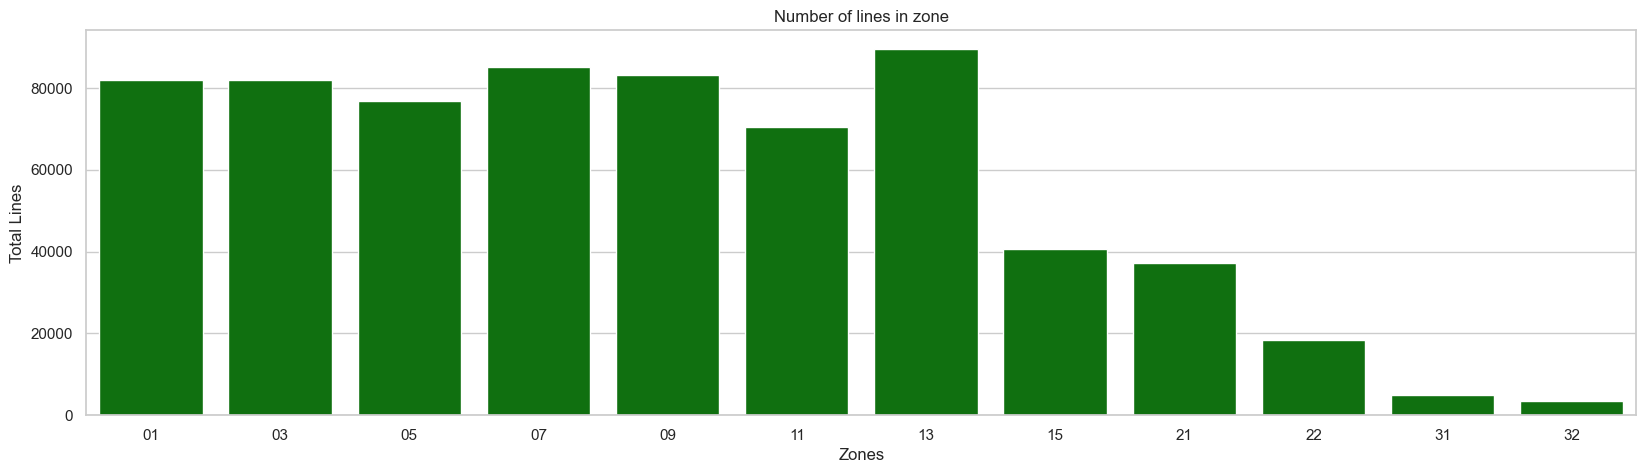

In [26]:
boxpicks=pd.DataFrame(newdf.groupby(['zone'])['InventorySku'].count().reset_index())
f=plt.figure()
ax = sns.barplot(data=boxpicks,x='zone',y='InventorySku',color='green');
ax.set_title("Number of lines in zone");
ax.set_xlabel("Zones");
ax.set_ylabel("Total Lines");
plt.show();
f.savefig('analyse/LinesPerZone.pdf');

In [27]:
dailypicks=pd.DataFrame(newdf.groupby(['InventorySku','Country','zone'])['Picked'].sum().reset_index())
table=pd.pivot_table(dailypicks,columns=['Country'],index=['InventorySku','zone'])
table.to_csv('analyse/pickscountrysku.csv')

#create a sorted list
sortedlist=dailypicks.sort_values(by='Picked')

In [28]:
#create total picks per sku, on month level
sku_overview_month=pd.DataFrame(newdf.groupby(['InventorySku','Date','Country','Area'])['Picked'].count().reset_index())
table=pd.pivot_table(sku_overview_month,index=['InventorySku','Area','Country'],columns=['Date'],values='Picked',aggfunc='mean')
table.to_csv('day2day.csv')

In [29]:
def network_plot(G,plot_zone):

    HOVER_TOOLTIPS = [("Sku", "@index")]

    plot = figure(tooltips = HOVER_TOOLTIPS,tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', plot_height=800, plot_width = 1750,title="Zone {}".format(plot_zone))

    network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))
    network_graph.node_renderer.glyph = Circle(size=15, fill_color='node_color')
    network_graph.node_renderer.hover_glyph = Circle(size=35, fill_color='red', line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color='orange', line_width=2)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color='darkgreen', line_width=2)

    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()

    plot.renderers.append(network_graph)

    x, y = zip(*network_graph.layout_provider.graph_layout.values())
    node_labels = list(G.nodes())


    source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
    labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)

    plot.renderers.append(labels)

    return plot

def make_network(df,plot_zone):

    _zone='zone'
    G=nx.from_pandas_edgelist(df.query('{0} == "{1}"'.format(_zone, plot_zone)),'Country','InventorySku','Picked')

    node_color=dict([])

    for start_node, end_node in G.nodes(data=True):
        if start_node in ['FR','BE','NL','AT','DE','CH','NO','IE','SE','FI','DK','GB','MT']:
            x='skyblue'
        else:
            x='peru'
        node_color[start_node]=x

    nx.set_node_attributes(G, name='node_color', values=node_color)

    return network_plot(G,plot_zone)


In [30]:
#dailypicks grouped on sku and date
# we count the number of times the sku is picked, not the total sum of the picked sku's_sku
dailypicks=pd.DataFrame(newdf.groupby(['InventorySku','Date','Country']).agg({'Picked': 'count'}).reset_index())
#need also total picks per sku
skutotaal= pd.DataFrame(dailypicks.groupby('InventorySku').sum(numeric_only=True).reset_index())
#need also total weight per sku
weighttotaal= pd.DataFrame(newdf.groupby('InventorySku')['Walk_Factor'].sum(numeric_only=True).reset_index())

# it is possible to make it even more detailed to incorporate the country
# dailypicks=pd.DataFrame(newdf.groupby(['InventorySku','Date','Country']).agg({'Picked': 'sum'}).reset_index())

In [31]:
#in a loop make for each sku a describtion, put it in a dataframe
skuset=pd.DataFrame(group.describe().rename(columns={'Picked':name[0]+"-"+name[1]}).squeeze()
                         for name, group in dailypicks.groupby(['InventorySku','Country']))

skuset.reset_index(inplace=True)
skuset = skuset.rename(columns = {'index':'Sku'})
skuset['Country']=skuset.Sku.str.split('-').str[1]
skuset['Inv_Sku']=skuset.Sku.str.split('-').str[0]
skuset.head(1)

# if country detail is needed, add country to groupby and use name[0]+"-"+name[1] in the rename
# then split the resulting field in SKU and Country: skuset['Country']=skuset.Inv_Sku.str.split('-').str[1] -- skuset['Sku']=skuset.Inv_Sku.str.split('-').str[0]

,Sku,count,mean,std,min,25%,50%,75%,max,Country,Inv_Sku
0,A001-SE,22.00,2.95,1.76,1.00,2.00,2.50,4.00,7.00,SE,A001


In [32]:
print('Number of skus picked {}, number of skus on the line {}'.format(dailypicks.InventorySku.nunique(), masterlist.Inv_Sku.nunique()))

Number of skus picked 693, number of skus on the line 819


In [33]:
#we have a mirrorsystem for all but the zones 21..32 double the capacity for the mirrored zones
def set_capacity(zone,x): 
    if zone == "21":
        return x
    if zone == "22":
        return x
    if zone == "31":
        return x
    if zone == "32":
        return x
    if zone == "15":
        return x
    
    return 2*x
    
masterlist['Capacity']=masterlist.apply(lambda x: set_capacity(x['zone'],x['Locator_Capacity']),axis=1)
masterlist.NbrOfLanes=masterlist.apply(lambda x: set_capacity(x['zone'],x['NbrOfLanes']),axis=1)

In [34]:
#Convert to an int for better representation
weighttotaal.Walk_Factor=weighttotaal.Walk_Factor.astype(int)
weighttotaal

,InventorySku,Walk_Factor
0,A001,154
1,A002,401
2,A003,1008
3,A004,245
4,A005,5178
...,...,...
688,A815,12
689,A816,78
690,A817,258
691,A818,132


In [35]:
masterlist

,Sell_sku,Inv_Sku,Description,Country,Locator,Locator_Mirror,Weight,Length,Width,Height,...,EA/Carton,Carton Length,Carton Width,Carton Height,Carton Weight,zone,level,lane,WBC,Capacity
0,A001,A001,NaN,SW/,01A02,02A02,767.00,113.00,113.00,208.00,...,6.00,34.50,23.50,21.70,"4,602.00",01,A,02,False,120
1,A002,A002,NaN,FI/SW/,01A04,02A04,614.00,100.00,100.00,120.00,...,12.00,41.00,31.00,24.50,"7,404.00",01,A,04,False,408
2,A003,A003,NaN,NL/,01A06,02A06,"1,137.00",138.00,138.00,210.00,...,6.00,41.50,28.00,22.00,"6,976.00",01,A,06,False,96
3,A004,A004,NaN,NO/,01A08,02A08,340.00,50.00,200.00,230.00,...,12.00,52.00,21.20,23.30,"4,080.00",01,A,08,False,168
4,A005,A005,NaN,BE/FR/,01A10,02A10,"1,140.00",138.00,138.00,210.00,...,6.00,41.50,28.00,22.00,"6,976.00",01,A,10,False,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,A815,A815,NaN,AU/,32N2D03,NaN,"1,726.00",315.00,240.00,110.00,...,3.00,52.00,41.50,30.50,"5,178.00",32,N2D,03,True,9
815,A816,A816,NaN,SW/,32N2D05,NaN,"1,699.00",315.00,240.00,110.00,...,3.00,51.00,40.00,31.00,"5,340.00",32,N2D,05,True,9
816,A817,A817,NaN,DA/,32N4B01,NaN,756.00,180.00,85.00,180.00,...,12.00,41.00,27.00,20.00,"8,880.00",32,N4B,01,True,36
817,A818,A818,NaN,FI/,32N4C01,NaN,39.00,45.00,45.00,75.00,...,40.00,24.50,20.00,17.50,"1,560.00",32,N4C,01,True,160


In [36]:
masterlist=pd.merge(masterlist[['Inv_Sku','Description','Locator','Capacity','NbrOfLanes','zone','level','lane','WBC','Barcode Enabled','Type', 'XQty']], 
         new_locations[['Inv_Sku','new_zone', 'new_level','new_lane','New_Lanes','New_Locator']],
                    left_on='Inv_Sku', right_on='Inv_Sku',how='right')

In [37]:
#create a dataset with masterlist data and summary data
#start creating a dataframe with all sku info
skuset = pd.merge(skuset,skutotaal,left_on='Inv_Sku', right_on='InventorySku')
skuset = pd.merge(skuset,weighttotaal,left_on='Inv_Sku', right_on='InventorySku')

Currentset=pd.merge(skuset, masterlist[['Inv_Sku','Description','Locator','New_Locator','Capacity','NbrOfLanes',
                                        'New_Lanes','zone','new_zone','level','new_level','lane','new_lane','WBC','Barcode Enabled','Type', 'XQty']], 
                    left_on='Inv_Sku', right_on='Inv_Sku',how='right')

#remove duplicate rows (same sku) and change some columnnames
Currentset.drop_duplicates(keep='first',inplace=True)
Currentset.drop(['Sku', 'InventorySku_x','InventorySku_y'], axis=1, inplace=True)
Currentset.query('Inv_Sku =="A234"')

#to_remove=Currentset[Currentset['max'] <= 1].index
#Currentset.drop(labels=to_remove,inplace=True)


,count,mean,std,min,25%,50%,75%,max,Country,Inv_Sku,...,zone,new_zone,level,new_level,lane,new_lane,WBC,Barcode Enabled,Type,XQty
403,26.00,5.62,3.89,1.00,3.00,6.00,7.00,20.00,DK,A234,...,09,09,A,A,06,06,False,Y,,1.00


In [38]:
Currentset[Currentset['Country'].isnull()]

,count,mean,std,min,25%,50%,75%,max,Country,Inv_Sku,...,zone,new_zone,level,new_level,lane,new_lane,WBC,Barcode Enabled,Type,XQty
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A037,...,01,01,C,C,31,31,False,Y,,1.00
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A052,...,01,01,D,D,23,23,False,N,,1.00
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A070,...,03,03,B,B,04,04,False,N,,1.00
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A081,...,03,03,C,C,02,02,False,Y,,1.00
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A104,...,03,03,D,D,23,23,False,N,,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A785,...,32,32,C,C,09,09,False,N,,1.00
1613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A795,...,32,32,D,D,11,11,False,N,,1.00
1616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A797,...,32,32,D,D,21,21,False,N,,1.00
1627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A805,...,32,32,M1D,M1D,01,01,True,N,,2.00


In [39]:
# BE CAREFULL -- works only correct when the aggragation of the pickes is summed, not counted -- needs to be adjusted in due time
# calculate the number of days of stock per SKU in relation to the given sales
# Available stock in days when sales is MAX
Currentset['days_cap_max']=Currentset.Capacity/Currentset['max']

#Available stock in days when sales is slightly above avarage
Currentset['days_cap_sales']=Currentset.Capacity/(Currentset['mean']+Currentset['std'])

# the other percentiles 25%, 50%, 75% we do not use
# these could be used when fine tuning the system

# calculate the number of lanes needed for a avarage sales day 
# for the avarage sales we add the mean sales and the standard devition of the mean together.
# these numbers are calculated with the describe function.
# if this is in general to low/high a 25% or 75% percentaile could be used.

Currentset['Req_lanes']=(Currentset['mean']+Currentset['std'])/(Currentset.Capacity/Currentset.NbrOfLanes)
Currentset.query('Inv_Sku =="A234"')

,count,mean,std,min,25%,50%,75%,max,Country,Inv_Sku,...,new_level,lane,new_lane,WBC,Barcode Enabled,Type,XQty,days_cap_max,days_cap_sales,Req_lanes
403,26.00,5.62,3.89,1.00,3.00,6.00,7.00,20.00,DK,A234,...,A,06,06,False,Y,,1.00,21.60,45.45,0.04


In [40]:
#This is where the magic happens For each SKU calculate the required number of lanes
# First set some boundaries
minwbsPicks = 5   # Used for the minimal amount of picks 
minPicks = 15
minReq = 0.35   # used to decide if a lane is needed
minMirror=1.15  # used to decide if a mirror is needed

def set_code_WBC(rlanes,picks,NbrOfLanes,DCode):
    # rlanes is the number of calculated required lanes
    # picks is the actual number of picks for the SKU
    # DCode indicates if it is a 2D coded SKU

    #The function return as soon as found the correct capacity

    if picks <= minwbsPicks:
        # SKU with low demand and low capacity needs
        if DCode == "Y":
            return "2D (WBS)"
        else:
            return "put in WBS"

    if picks <= minPicks and rlanes < minReq:
        # SKU with low demand and low capacity needs
        if DCode == "Y":
            return "2D (WBS)"
        else:
            return "put in WBS"

    if picks < 2*minPicks and rlanes < 2*minReq:
        # SKU with low demand and needed capacity but to large for a WBS
        if DCode == "Y":
            return "2D (Mezzanine)"
        else:
            return 'Mezzanine'
    
    if picks > 2*minPicks and rlanes <=minMirror:
        # Sku to large for mezzanine but can without mirror
        return 'NO Mirror'

    if rlanes > (NbrOfLanes+1.25) :
        # The current capacity is to low
        return 'More lanes'

    if rlanes < (NbrOfLanes-1.25) :
        # The current capacity is to high
        return 'Less lanes'

    else: 
        # capacity is correct
        return 'Correct'

# calculate the needed capacity per SKU    
Currentset['Change']=Currentset.apply(lambda x: set_code_WBC(x['Req_lanes'],x['mean'],x['NbrOfLanes'],x['Barcode Enabled']),axis=1)

## STEP 5

In [41]:
#Show the first few SKU's with the lowest available stock
Currentset.nsmallest(50,'days_cap_sales')\
[['Inv_Sku','zone','days_cap_sales','days_cap_max','Picked','mean','Capacity','NbrOfLanes','Req_lanes','Change']].style.format("{:20,.2f}")\
.format({"Inv_Sku": lambda x:x.upper()}).bar(subset=["days_cap_sales",], color='green')\
.format({"Change": lambda x:x.lower()})\
.format({'zone':lambda x:x.lower()})


,Inv_Sku,zone,days_cap_sales,days_cap_max,Picked,mean,Capacity,NbrOfLanes,Req_lanes,Change
989,A455,21,0.741257,0.787402,331.000000,82.750000,100.000000,1.000000,1.349060,Correct
987,A453,21,0.762479,0.400000,377.000000,37.700000,60.000000,2.000000,2.623022,Correct
489,A274,09,0.809408,0.971787,390.000000,164.500000,310.000000,10.000000,12.354710,More lanes
1562,A750,31,1.021270,0.642857,112.000000,4.666667,9.000000,1.000000,0.979173,put in WBS
426,A246,09,1.064374,0.624277,2680.000000,134.000000,216.000000,2.000000,1.879040,Correct
461,A261,09,1.148349,0.683544,3379.000000,129.961538,216.000000,2.000000,1.741631,Correct
171,A097,03,1.218077,1.113402,1692.000000,116.857143,216.000000,2.000000,1.641932,Correct
150,A086,03,1.265320,0.780000,4260.000000,163.846154,312.000000,2.000000,1.580627,Correct
994,A459,21,1.533303,0.895522,254.000000,23.090909,60.000000,1.000000,0.652187,Mezzanine
167,A093,03,1.565950,1.116279,5892.000000,163.038462,384.000000,6.000000,3.831539,Less lanes


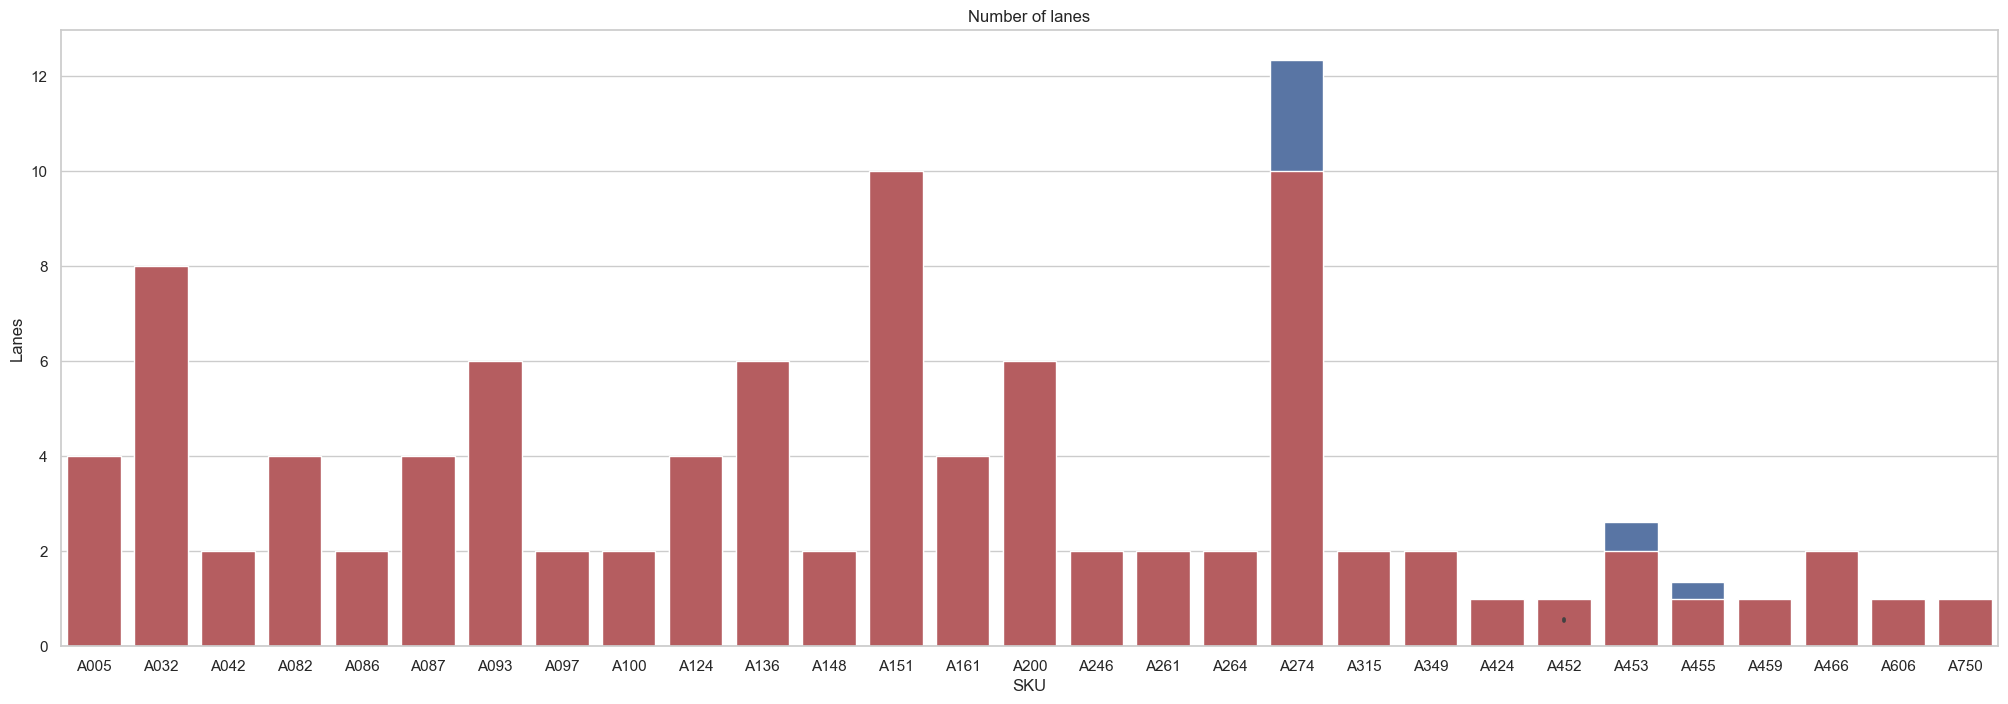

In [42]:
#make it visible
dataset=Currentset.nsmallest(30,'days_cap_sales').sort_values('Inv_Sku')
plt.figure(figsize=(25,8))
sns.barplot(data=dataset,y='Req_lanes',x='Inv_Sku',orient='v',color='b');
ax=sns.barplot(data=dataset,y='NbrOfLanes',x='Inv_Sku',orient='v',color='r');
ax.set_title("Number of lanes");
ax.set_xlabel("SKU");
ax.set_ylabel("Lanes");


In [43]:
#The following part are all declarations for the HTML file we create with bokeh
output_file("analyse/zone_reprofile_info.html")
#output_notebook()

#levels and lanes in the pickline
levels = ["A", "B", "C", "D"] 

lanes = ['01','03', '05', '07','09','11','13','21','23','25','27','29','31','33','02','04','06','08','10','12','14','22','24','26','28','30','32','34'] 
mezzanine = ['01','03', '05', '07','09', '11','13','21','23','25','27','29','31','33','41','43','45','47','49','51','53']

mezzanine_level=["C", "D"] 
level_21=['A1A', 'A1B', 'A1C','A1D', 'A1E',
'B1A','B1B','B1C','B1D','B1E',
'B2A','B2B','B2C','B2D','B2E',
'B3A','B3B','B3C','B3D','B3E',
'B4A','B4B','B4C','B4D','B4E',
'B5A','B5B','B5C','B5D','B5E',
'C1A','C1B','C1C','C1D','C1E',
'C2A','C2B','C2C','C2D','C2E',
'C3A','C3B','C3C','C3D','C3E',
'C4A','C4B','C4C','C4D','C4E',
'C5A','C5B','C5C','C5D','C5E',
'D1A','D1B','D1C','D1D','D1E',
'D2A','D2B','D2C','D2D','D2E',
'D3A','D3B','D3C','D3D','D3E',
'D4A','D4B','D4C','D4D','D4E',
'D5A','D5B','D5C','D5D','D5E']
lanes_21=['01','02','03','04','05']

level_22=['E1A','E1B','E1C','E1D','E1E',
'E2A','E2B','E2C','E2D','E2E',
'E3A','E3B','E3C','E3D','E3E',
'E4A','E4B','E4C','E4D','E4E',
'E5A','E5B','E5C','E5D','E5E',
'F1A','F1B','F1C','F1D','F1E',
'F2A','F2B','F2C','F2D','F2E',
'F3A','F3B','F3C','F3D','F3E',
'F4A','F4B','F4C','F4D','F4E',
'F5A','F5B','F5C','F5D','F5E']
level_31=['J1A','J1B','J1C','J1D','J1E',
'J3A','J3B','J3C','J3D','J3E',
'J5A','J5B','J5C','J5D','J5E',
'K1A','K1B','K1C','K1D','K1E',
'K2A','K2B','K2C','K2D','K2E']
level_32=['M1A','M1B','M1C','M1D','M1E',
'N1A','N1B','N1C','N1D','N1E',
'N2A','N2B','N2C','N2D','N2E',
'N3A','N3B','N3C','N3D','N3E',
'N4A','N4B','N4C','N4D','N4E',
]
Zones = ['01', '02','03','04','05','06','07','08','09','10','11','12','13','14','15','21','22','31','32']
Zones_short =  ['01','03','05','07','09','11','13','15','21','22','31','32']
Months=['01','02','03','04','05','06','07','08','09','10','11','12']

#create a general overview of pickes per zone last period.
general_plot=pd.DataFrame(picklist.groupby(['month','Locator'])['Picked'].sum().reset_index())
general_plot['zone']=general_plot.Locator.str.extract(r"(\d{2})")
general_plot=pd.DataFrame(general_plot.groupby(['zone','month'])['Picked'].sum().reset_index())

x = [ (Zone, Month) for Zone in Zones for Month in Months ]
general_plot['x']=tuple(zip(general_plot.zone,general_plot.month))

source=general_plot.copy()

general = figure(x_range=FactorRange(*x), plot_height=450, plot_width = 1500,title="picks per zone",
           toolbar_location=None, tools="")

general.vbar(x='x', top='Picked', width=0.9, source=source)


GlyphRenderer(id='1026', ...)

In [44]:
def plot_zone_bars(df,titel):

    #create a general overview of pickes per zone last period.
    general_plot=pd.DataFrame(df.groupby(['month','Locator'])['Picked'].sum().reset_index())
    general_plot['zone']=general_plot.Locator.str.extract(r"(\d{2})")
    general_plot=pd.DataFrame(general_plot.groupby(['zone','month'])['Picked'].sum().reset_index())

    x = [ (Zone, Month) for Zone in Zones for Month in Months ]
    
    general_plot['x']=tuple(zip(general_plot.zone,general_plot.month))

    source=general_plot.copy()

    general = figure(x_range=FactorRange(*x), plot_height=450, plot_width = 2000,title=titel,
           toolbar_location=None, tools="")

    general.vbar(x='x', top='Picked', width=0.9, source=source)
    return general

In [45]:
def plot_zone(df,titel,groups,levels):
    TOOLTIPS = [
        ("Sku:", "@Inv_Sku"),
        ("Country:", "@Country"),
        ("Info", "@Description"),
        ("Daily picks", "@mean{0.0}"),
        ("Current & needed lanes", "@{NbrOfLanes} / @Req_lanes{0.00}"),
        ("factor", "@{Walk_Factor}"),
        ("2D Scancode","@{Barcode Enabled}"),
         ("new location","@{New_Locator}")
    ]
    cmap1 = {
        "2D (Mezzanine)"   : "#87ceeb",
        "Mezzanine"     : "#ffc0cb",
        "NO Mirror"      : "#0000ff",
        "Less lanes" : "#ffa500",
        "More lanes" : "#ffff00",
        "Correct" : "#008000",
        "put in WBS" : "#8E8E38",
        "2D (WBS)": "#4876FF"
    }
    
    plot_width = len(groups)*65
    plot_height= len(levels)*95
    
    p = figure(title=titel, 
               plot_width=plot_width, 
               plot_height=plot_height,
               x_range=groups, y_range=levels,
               tools="hover", 
               toolbar_location=None, 
               tooltips=TOOLTIPS)

    r = p.rect("lane", "level", 0.95, 0.95, 
               source=df, 
               fill_alpha=0.6, 
               color=factor_cmap('Change', palette=list(cmap1.values()), factors=list(cmap1.keys())))
               #color=factor_cmap('Change', palette=list(cmap.values()), factors=list(cmap.keys())))

    text_props = {"source": df, "text_align": "left", "text_baseline": "middle"}

    x = dodge("lane", -0.4, range=p.x_range)

    p.text(x=x, y="level", text="Inv_Sku", text_font_style="bold",text_font_size="14px", **text_props)

    p.text(x=x, y=dodge("level", 0.3, range=p.y_range), text="Locator",text_font_size="11px", **text_props)
    p.text(x=x, y=dodge("level", 0.15, range=p.y_range), text="Barcode Enabled",text_font_size="11px", **text_props)
    p.text(x=x, y=dodge("level", -0.35, range=p.y_range), text="Picked",text_font_size="11px", **text_props) # or take NrOfLanes
    p.text(x=x, y=dodge("level", -0.2, range=p.y_range), text="Walk_Factor",text_font_size="11px", **text_props) # or take Picked
    p.rect(x=dodge("lane", 1 , range=p.x_range),y= "level",width= 0.65, height=0.50,source=df.query('NbrOfLanes >= 4'),fill_alpha=0.6,color="#333333")
    p.rect(x=dodge("lane", 2 , range=p.x_range),y= "level",width= 0.65, height=0.50,source=df.query('NbrOfLanes >= 6'),fill_alpha=0.6,color="#666666")
    p.rect(x=dodge("lane", 3 , range=p.x_range),y= "level",width= 0.65, height=0.50,source=df.query('NbrOfLanes >= 8'),fill_alpha=0.6,color="#999999")
    p.rect(x=dodge("lane", 4 , range=p.x_range),y= "level",width= 0.65, height=0.50,source=df.query('NbrOfLanes >= 10'),fill_alpha=0.6,color="#999999")
    p.rect(x=dodge("lane", 5 , range=p.x_range),y= "level",width= 0.65, height=0.50,source=df.query('NbrOfLanes >= 12'),fill_alpha=0.6,color="#999999")

    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_standoff = 0
    p.hover.renderers = [r] # only hover element boxes
   
    return p

def  plot_reprofile(df,titel,groups,levels):
    TOOLTIPS = [
        ("Sku:", "@Inv_Sku"),
        ("Old_locatiion:", "@Locator"),
    ]
    cmap1 = {
        "2D (Mezzanine)"   : "#87ceeb",
        "Mezzanine"     : "#ffc0cb",
        "NO Mirror"      : "#0000ff",
        "Less lanes" : "#ffa500",
        "More lanes" : "#ffff00",
        "Correct" : "#008000",
        "put in WBS" : "#8E8E38",
        "2D (WBS)": "#4876FF"
    }
    
  
    plot_width = len(groups)*65
    plot_height= len(levels)*95
    
    p = figure(title=titel, 
               plot_width=plot_width, 
               plot_height=plot_height,
               x_range=groups, y_range=levels,
               tools="hover", 
               toolbar_location=None, 
               tooltips=TOOLTIPS)

    r = p.rect("new_lane", "new_level", 0.95, 0.95, 
               source=df, 
               fill_alpha=0.6, 
               color=factor_cmap('Change', palette=list(cmap1.values()), factors=list(cmap1.keys())))
               #color=factor_cmap('Change', palette=list(cmap.values()), factors=list(cmap.keys())))

    text_props = {"source": df, "text_align": "left", "text_baseline": "middle"}

    x = dodge("new_lane", -0.4, range=p.x_range)

    p.text(x=x, y="new_level", text="Inv_Sku", text_font_style="bold",text_font_size="14px", **text_props)

    p.text(x=x, y=dodge("new_level", 0.3, range=p.y_range), text="New_Locator",text_font_size="11px", **text_props)
    p.text(x=x, y=dodge("new_level", 0.15, range=p.y_range), text="Barcode Enabled",text_font_size="11px", **text_props)
    p.text(x=x, y=dodge("new_level", -0.35, range=p.y_range), text="Picked",text_font_size="11px", **text_props) # or take NrOfLanes
    p.text(x=x, y=dodge("new_level", -0.2, range=p.y_range), text="Walk_Factor",text_font_size="11px", **text_props) # or take Picked
    p.rect(x=dodge("new_lane", 1 , range=p.x_range),y= "new_level",width= 0.65, height=0.50,source=df.query('New_Lanes >= 4'),fill_alpha=0.6,color="#333333")
    p.rect(x=dodge("new_lane", 2 , range=p.x_range),y= "new_level",width= 0.65, height=0.50,source=df.query('New_Lanes >= 6'),fill_alpha=0.6,color="#666666")
    p.rect(x=dodge("new_lane", 3 , range=p.x_range),y= "new_level",width= 0.65, height=0.50,source=df.query('New_Lanes >= 8'),fill_alpha=0.6,color="#999999")
    p.rect(x=dodge("new_lane", 4 , range=p.x_range),y= "new_level",width= 0.65, height=0.50,source=df.query('New_Lanes >= 10'),fill_alpha=0.6,color="#999999")
    p.rect(x=dodge("new_lane", 5 , range=p.x_range),y= "new_level",width= 0.65, height=0.50,source=df.query('New_Lanes >= 12'),fill_alpha=0.6,color="#999999")

    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_standoff = 0
    p.hover.renderers = [r] # only hover element boxes
   
    return p


In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 6 to 1562
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   count            30 non-null     float64
 1   mean             30 non-null     float64
 2   std              30 non-null     float64
 3   min              30 non-null     float64
 4   25%              30 non-null     float64
 5   50%              30 non-null     float64
 6   75%              30 non-null     float64
 7   max              30 non-null     float64
 8   Country          30 non-null     object 
 9   Inv_Sku          30 non-null     object 
 10  Picked           30 non-null     float64
 11  Walk_Factor      30 non-null     float64
 12  Description      0 non-null      float64
 13  Locator          30 non-null     object 
 14  New_Locator      30 non-null     object 
 15  Capacity         30 non-null     float64
 16  NbrOfLanes       30 non-null     float64
 17  New_Lanes        30 n

In [47]:
dataset=Currentset.query('zone == "01"')
df = dataset.copy()
zone_01 = plot_zone(df,"Sku's in zone 01",lanes,levels)

dataset=Currentset.query('new_zone == "01"')
df = dataset.copy()
zone_01_n = plot_reprofile(df,"Sku's in zone 01",lanes,levels)

dataset=Currentset.query('zone == "03"')
df = dataset.copy()
zone_03 = plot_zone(df,"Sku's in zone 03",lanes,levels)

dataset=Currentset.query('new_zone == "03"')
df = dataset.copy()
zone_03_n = plot_reprofile(df,"Sku's in zone 03",lanes,levels)

dataset=Currentset.query('zone == "05"')
df = dataset.copy()
zone_05 = plot_zone(df,"Sku's in zone 05",lanes,levels)

dataset=Currentset.query('new_zone == "05"')
df = dataset.copy()
zone_05_n = plot_reprofile(df,"Sku's in zone 05",lanes,levels)

dataset=Currentset.query('zone == "07"')
df = dataset.copy()
zone_07 = plot_zone(df,"Sku's in zone 07",lanes,levels)

dataset=Currentset.query('new_zone == "07"')
df = dataset.copy()
zone_07_n =plot_reprofile(df,"Sku's in zone 07",lanes,levels)

dataset=Currentset.query('zone == "09"')
df = dataset.copy()
zone_09 = plot_zone(df,"Sku's in zone 09",lanes,levels)

dataset=Currentset.query('new_zone == "09"')
df = dataset.copy()
zone_09_n = plot_reprofile(df,"Sku's in zone 09",lanes,levels)

dataset=Currentset.query('zone == "11"')
df = dataset.copy()
zone_11 = plot_zone(df,"Sku's in zone 11",lanes,levels)

dataset=Currentset.query('new_zone == "11"')
df = dataset.copy()
zone_11_n = plot_reprofile(df,"Sku's in zone 11",lanes,levels)

dataset=Currentset.query('zone == "13"')
df = dataset.copy()
zone_13 = plot_zone(df,"Sku's in zone 13",lanes,levels)

dataset=Currentset.query('new_zone == "13"')
df = dataset.copy()
zone_13_n = plot_reprofile(df,"Sku's in zone 13",lanes,levels)

dataset=Currentset.query('zone == "15"')
df = dataset.copy()
zone_15 = plot_zone(df,"Sku's in zone 15",lanes,levels)

dataset=Currentset.query('new_zone == "15"')
df = dataset.copy()
zone_15_n = plot_reprofile(df,"Sku's in zone 15",lanes,levels)

dataset=Currentset.query('zone == "21"')
df = dataset.copy()
zone_21 = plot_zone(df,"Sku's in zone 21",mezzanine,levels)
zone_21w = plot_zone(df,"Sku's in WBS 21",lanes_21,level_21) 

dataset=Currentset.query('new_zone == "21"')
df = dataset.copy()
zone_21_n = plot_reprofile(df,"Sku's in zone 21",mezzanine,levels)

#zone_21w_n = make_network(sortedlist,'21')

dataset=Currentset.query('zone == "22"')
df = dataset.copy()
zone_22 = plot_zone(df,"Sku's in zone 22",mezzanine,levels)
zone_22w = plot_zone(df,"Sku's in WBS 22",lanes_21, level_22)

dataset=Currentset.query('new_zone == "22"')
df = dataset.copy()
zone_22_n = plot_reprofile(df,"Sku's in zone 22",mezzanine,levels)

#zone_22w_n = make_network(sortedlist,'22')

dataset=Currentset.query('zone == "31"')
df = dataset.copy()
zone_31 = plot_zone(df,"Sku's in zone 31",mezzanine,levels)
zone_31_n = plot_zone(df,"Sku's in zone 31",mezzanine,levels)

dataset=Currentset.query('new_zone == "31"')
df = dataset.copy()
zone_31w = plot_reprofile(df,"Sku's in WBS 31",lanes_21, level_31)


dataset=Currentset.query('zone == "32"')
df = dataset.copy()
zone_32 = plot_zone(df,"Sku's in zone 32",mezzanine,levels)
zone_32_n = plot_zone(df,"Sku's in zone 32",mezzanine,levels)

dataset=Currentset.query('new_zone == "32"')
df = dataset.copy()
zone_32w = plot_reprofile(df,"Sku's in WBS 32",lanes_21, level_32)

df=picklist
general = plot_zone_bars(df,"picks per zone")

tab0 = Panel(child = general,title = 'Totalen')
tab1 = Panel(child = column(zone_01,zone_01_n), title = 'Zone 01 - Mirrored')
tab3 = Panel(child = column(zone_03,zone_03_n), title = 'Zone 03 - Mirrored')
tab5 = Panel(child = column(zone_05,zone_05_n), title= 'Zone 05 - Mirrored')
tab7 = Panel(child = column(zone_07,zone_07_n), title = 'Zone 07 - Mirrored')
tab9 = Panel(child = column(zone_09,zone_09_n), title = 'Zone 09 - Mirrored')
tab11 = Panel(child = column(zone_11,zone_11_n), title = 'Zone 11 - Mirrored')
tab13 = Panel(child = column(zone_13,zone_13_n), title = 'Zone 13 - Mirrored')
tab15 = Panel(child = column(zone_15,zone_15_n), title = 'Zone 15')
tab21 = Panel(child = column(zone_21,zone_21_n), title = 'Zone 21')
tab22 = Panel(child = column(zone_22,zone_22_n), title = 'Zone 22')
tabwbc = Panel(child = row(zone_21w,zone_22w,zone_31w,zone_32w), title = 'WBS 21 .. 32')
tab31 = Panel(child = column(zone_31,zone_31_n), title = 'Zone 31')
tab32 = Panel(child = column(zone_32,zone_32_n), title = 'Zone 32')

tabs_object1 = Tabs(tabs = [tab0,tab1,tab3,tab5,tab7,tab9,tab11,tab13,tab15,tab21,tab22,tab31,tab32,tabwbc])

show(tabs_object1)


In [48]:
#create the input file for the balance sheet
Currentset['Area'] = Currentset.apply(lambda x: Area_set(x['zone']),axis=1)
reprofile_sheet =Currentset[['Inv_Sku','mean','XQty','Locator','NbrOfLanes','Country','Req_lanes','Area']]\
    .pivot(index=['Inv_Sku','XQty','Locator','Area','NbrOfLanes'],columns=['Country'],values='mean')
reprofile_sheet.to_csv('balance_data.csv')

In [49]:
Currentset.query('Locator == "01A10"')

,count,mean,std,min,25%,50%,75%,max,Country,Inv_Sku,...,new_lane,WBC,Barcode Enabled,Type,XQty,days_cap_max,days_cap_sales,Req_lanes,Change,Area
5,26.00,58.08,34.00,17.00,38.25,50.00,62.75,152.00,BE,A005,...,10,False,N,,1.00,1.34,2.22,1.81,Less lanes,A1
6,26.00,64.50,45.34,13.00,35.00,52.00,75.75,185.00,FR,A005,...,10,False,N,,1.00,1.10,1.86,2.15,Less lanes,A1


In [50]:
reprofile_sheet.sort_values(by='Locator')

,,,,Country,NaN,AT,BE,CH,DE,DK,FI,FR,GB,IE,MT,NL,NO,SE
Inv_Sku,XQty,Locator,Area,NbrOfLanes,,,,,,,,,,,,,,
A001,1.00,01A02,A1,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.95
A002,1.00,01A04,A1,2.00,NaN,NaN,NaN,NaN,NaN,NaN,6.58,NaN,NaN,NaN,NaN,NaN,NaN,7.86
A003,1.00,01A06,A1,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.69,NaN,NaN
A004,1.00,01A08,A1,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.81,NaN
A005,1.00,01A10,A1,4.00,NaN,NaN,58.08,NaN,NaN,NaN,NaN,64.50,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A811,1.00,32N2C01,C,2.00,NaN,NaN,NaN,NaN,NaN,1.84,NaN,NaN,NaN,NaN,NaN,NaN,3.08,NaN
A812,1.00,32N2C03,C,1.00,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A813,1.00,32N2C05,C,1.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
